# check and validate

routines to check the output of Bias_Correct_2_Livneh procedure

In [1]:
import xarray as xr
import numpy as np 
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns

# import quantile_mapping # from same folder.
import multiprocessing
import itertools
import time

### CMIP5


In [33]:
path_bc="/glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC4"
# models = ["CanESM5", "CMCC-CM2-SR5", "MIROC-ES2L", "MPI-M.MPI-ESM1-2-LR", "NorESM2-MM"] 
models = ['CanESM2', 'CCSM4','CMCC-CM', 'CNRM-CM5','MIROC5', 'MRI-CGCM3']  # GFDL-CM3
    
scenarios = ["rcp45", "rcp85"]

In [32]:
dt='3hr'
f"{path_bc}/{model}_{scen}/{dt}/icar_3hr_livgrid_{model}_{scen}_*.nc"

'/glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC4/MPI-M.MPI-ESM1-2-LR_ssp585/3hr/icar_3hr_livgrid_MPI-M.MPI-ESM1-2-LR_ssp585_*.nc'

### CMIP6

In [ ]:
path_bc="/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_livBC3"
models = ["CanESM5", "CMCC-CM2-SR5", "MIROC-ES2L", "MPI-M.MPI-ESM1-2-LR", "NorESM2-MM"] 
# scenarios = ["ssp245_2004", "ssp245_2049", "ssp370_2004", "ssp370_2049", "ssp585_2004", "ssp585_2049"]
scenarios = ["ssp245", "ssp370", "ssp585"]

### functions

In [34]:
def check_output_nans( model, scen, var='rsds', path=path_bc, dt='3hr'):
    """  """
    # for model in models:
    #     for scen in scenarios:
    if dt is None:
        files=sorted(glob.glob(f"{path}/{model}_{scen}/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    else:
        files=sorted(glob.glob(f"{path}/{model}_{scen}/{dt}/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    
    print(f"\n checking {model} {scen} {len(files)} files")        
    for f in files:
        dsl = xr.open_dataset( f )
        for t in range(len(dsl.time)):

            cnt = np.count_nonzero(np.isnan(dsl[var].isel(time=t).values))
            if t==0:
                cnt0 = cnt
            else:
                if  cnt>cnt0: print(f" {model} {scen}:  {dsl.time.isel(time=t).values} has NaNs in {var} ")
                
    print(f" - - {model} done - -")        

In [4]:
def check_missing_time( model, scen, path=path_bc, dt=None):
    """Check for missing timesteps"""

    if dt is not None:
        files  = sorted(glob.glob( f"{path}/{model}_{scen}/{dt}/icar_*"))
    else:
        files  = sorted(glob.glob( f"{path}/{model}_{scen}/icar_*"))

    print(f"\n checking {model} {scen} {len(files)} files")        
    for i in range(len(files)):
        f = files[i:i+2]  # open 2 files so we catch missing data at the end of a month
        
        ds5 = xr.open_mfdataset( f )
    
        idx = np.where(ds5.time.diff(dim='time').values > ds5.time.diff(dim='time').min().values )
        
        if len(idx[0])==1:
            print( #f.split('/')[-1], idx[0],
                  model, scen, ds5.time.values[ idx[0][0] ] 
                 )
        elif len(idx[0])>1:
            for l in len(idx[0]):
                print( 
                      model, scen, ds5.time.values[ idx[0][l] ] 
                     )
            

In [5]:
def check_Tmin_max( model, scen, path_bc, dt='daily'):
    """ check if Tmin is larger than Tmax (daily files only)"""
    
    if dt is not None:
        files  = sorted(glob.glob( f"{path}_{model}/{scen}/{dt}/icar_*"))
    else:
        files  = sorted(glob.glob( f"{path}_{model}/{scen}/icar_*"))

    print(f"\n checking {model} {scen} {len(files)} files")        
    for i in range(len(files)):
        f = files[i:i+2]  # open 2 files so we catch missing data at the end of a month
        
        ds5 = xr.open_mfdataset( f )
    
        cnt =  np.sum( ds5.Tmin.values > ds5.Tmax.values ) 
        print(model, scen, cnt)
        
        if cnt > 0: # if len(cnt[0]) > 0:
            idx = np.where( ds5.Tmin.values > ds5.Tmax.values )
            # print(f" Tmin> Tmax @ {ds5.time[idx[0][0] }")
            
            if len(idx[0])==1:
                print( #f.split('/')[-1], idx[0],
                      model, scen, ds5.time.values[ idx[0][0] ] 
                     )
            elif len(idx[0])>1:
                for l in len(idx[0]):
                    print( 
                          model, scen, ds5.time.values[ idx[0][l] ] 
                         )
            

In [39]:
def check_ta2m_low( model, scen, path=path_bc, dt='3hr'):
    """ check for excessively low temperatures."""


    
    var='ta2m'
    
    files=sorted(glob.glob(f"{path}/{model}_{scen}/3hr/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    print(f"  {model} {scen}: checking {len(files)} files ...")        

    for f in files:
        dsl = xr.open_dataset( f )

        if(dsl.ta2m.min(dim='time').values <100).any():
            print(f" {f} has low temps!")
            
            
    print(f" - - {model} {scen} done - -")        

In [44]:
def plot_pcp_ts(model, scen, path=path_bc, dt='3hr',lat_idx=150, lon_idx=150):
    """ Plot timeseries of precipitation, annual sums """
    
    if dt=='3hr':  pcp_var='precip_dt'
    elif dt=='daily':  pcp_var='Prec'

    
    files=sorted(glob.glob(f"{path}/{model}_{scen}/3hr/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    # print(f"  {model} {scen}: checking {len(files)} files ...")   

    fig, ax = plt.subplots( 1, 2, figsize=(14,7))

    for i,f in enumerate(files):
        ds=xr.open_dataset(f) 

        ax[0].plot( ds[pcp_var].isel(lat=lat_idx).isel(lon=lon_idx) ) 
        # ax[0].plot(ds.time, ds[pcp_var].isel(lat=lat_idx).isel(lon=lon_idx) ) 
        ax[0].set_title( f.split('/')[-1].split('livgrid_')[-1] , fontsize=10)

        pcp_ann=ds[pcp_var].isel(lat=lat_idx).isel(lon=lon_idx).resample(time='1Y').sum()
        ax[1].plot(pcp_ann.time, pcp_ann ) 
        ax[1].set_title( "annual sum" , fontsize=10)
        
    fig.suptitle(f" {pcp_var} at j,i = {lat_idx} {lon_idx}  ")
    plt.show()

In [41]:
def plot_ta2m_ts(model, scen, path=path_bc, dt='3hr', lat_idx=150, lon_idx=150):
    """ Plot timeseries of ta2m, annual max and min """

    if dt=='3hr':  tvar='ta2m'
    elif dt=='daily':  tvar='Tmax'

    
    files=sorted(glob.glob(f"{path}/{model}_{scen}/3hr/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    

    fig, ax = plt.subplots( 1, 3, figsize=(16,6))

    for i,f in enumerate(files):
        ds=xr.open_dataset(f) 

        ax[0].plot(ds.time, ds[tvar].isel(lat=lat_idx).isel(lon=lon_idx) ) 
        ax[0].set_title( f.split('/')[-1].split('livgrid_')[-1] , fontsize=10)

        tmax_ann=ds[tvar].isel(lat=lat_idx).isel(lon=lon_idx).resample(time='1Y').max()
        ax[1].plot(tmax_ann.time, tmax_ann ) 
        ax[1].set_title( "annual maximum" , fontsize=10)

        tmin_ann=ds[tvar].isel(lat=lat_idx).isel(lon=lon_idx).resample(time='1Y').min()
        ax[2].plot(tmin_ann.time, tmin_ann ) 
        ax[2].set_title( "annual minimum" , fontsize=10)

        
    fig.suptitle(f" {tvar} at j,i = {lat_idx} {lon_idx}  ")
    plt.show()

## Run some Checks

### Check for NaNs

In [35]:

with multiprocessing.Pool(processes=len(models)*len(scenarios)) as pool:
    results = pool.starmap(check_output_nans, list(itertools.product(models, scenarios)))



 checking CNRM-CM5 rcp45 19 files
 checking MRI-CGCM3 rcp45 19 files
 checking MIROC5 rcp45 19 files
 checking MIROC5 rcp85 19 files




 checking CMCC-CM rcp85 19 files
 checking CNRM-CM5 rcp85 19 files


 checking MRI-CGCM3 rcp85 19 files

 checking CanESM2 rcp85 19 files
 checking CCSM4 rcp85 19 files


 checking CCSM4 rcp45 19 files

 checking CMCC-CM rcp45 19 files

 checking CanESM2 rcp45 19 files
 - - CCSM4 done - -
 - - MIROC5 done - -
 - - CanESM2 done - -
 - - CCSM4 done - -
 - - CMCC-CM done - -
 - - MRI-CGCM3 done - -
 - - MIROC5 done - -
 - - CMCC-CM done - -
 - - CNRM-CM5 done - -
 - - MRI-CGCM3 done - -
 - - CanESM2 done - -
 - - CNRM-CM5 done - -


### Check for missing timesteps

In [36]:

with multiprocessing.Pool(processes=len(models)*len(scenarios)) as pool:
    results = pool.starmap(check_missing_time, list(itertools.product(models, scenarios)))



 checking CanESM2 rcp85 0 files
 checking CCSM4 rcp45 0 files
 checking CCSM4 rcp85 0 files
 checking CMCC-CM rcp45 0 files
 checking CanESM2 rcp45 0 files


 checking MRI-CGCM3 rcp45 0 files



 checking CNRM-CM5 rcp85 0 files
 checking MIROC5 rcp45 0 files
 checking CMCC-CM rcp85 0 files

 checking CNRM-CM5 rcp45 0 files
 checking MRI-CGCM3 rcp85 0 files
 checking MIROC5 rcp85 0 files







### Check for Tmin > Tmax (daily files)

In [ ]:

with multiprocessing.Pool(processes=len(models)*len(scenarios)) as pool:
    results = pool.starmap(check_Tmin_max, list(itertools.product(models, scenarios)))

### Check for low ta2m values (3hr)

In [42]:

t0=time.time()
with multiprocessing.Pool(processes=len(models)*len(scenarios)) as pool:
    results = pool.starmap(check_ta2m_low, list(itertools.product(models, scenarios)))

print(time.time()-t0)

  CCSM4 rcp45: checking 19 files ...  CanESM2 rcp45: checking 19 files ...  CanESM2 rcp85: checking 19 files ...  CMCC-CM rcp85: checking 19 files ...
  CCSM4 rcp85: checking 19 files ...


  MRI-CGCM3 rcp85: checking 19 files ...  MIROC5 rcp85: checking 19 files ...
  MRI-CGCM3 rcp45: checking 19 files ...


  CMCC-CM rcp45: checking 19 files ...
  CNRM-CM5 rcp45: checking 19 files ...  CNRM-CM5 rcp85: checking 19 files ...  MIROC5 rcp45: checking 19 files ...


 /glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC4/CNRM-CM5_rcp45/3hr/icar_3hr_livgrid_CNRM-CM5_rcp45_2020-2024.nc has low temps!
 /glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC4/CCSM4_rcp45/3hr/icar_3hr_livgrid_CCSM4_rcp45_2020-2024.nc has low temps!
 /glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC4/CNRM-CM5_rcp45/3hr/icar_3hr_livgrid_CNRM-CM5_rcp45_2025-2029.nc has low temps!
 /glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC4/CNRM-CM5_rcp45/3hr/icar_3hr_livgrid_CNRM-CM5_rcp45_2040-2044.nc has low temps!
 /glade/campai

## Plots

### Plot timeseries of random gridpoints

In [67]:
ds.time.dt.calendar=='noleap'

True

/glade/derecho/scratch/bkruyt/tmp/ipykernel_56624/1149361743.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_np = ds.time.astype('datetime64[h]')


2005-01-01 00:00:00 2009-12-31 21:00:00 2005-01-01T00:00:00.000000000 2009-12-31T21:00:00.000000000


/glade/derecho/scratch/bkruyt/tmp/ipykernel_56624/1149361743.py:15: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_np = ds.time.astype('datetime64[h]')


2010-01-01 00:00:00 2014-12-31 21:00:00 2010-01-01T00:00:00.000000000 2014-12-31T21:00:00.000000000


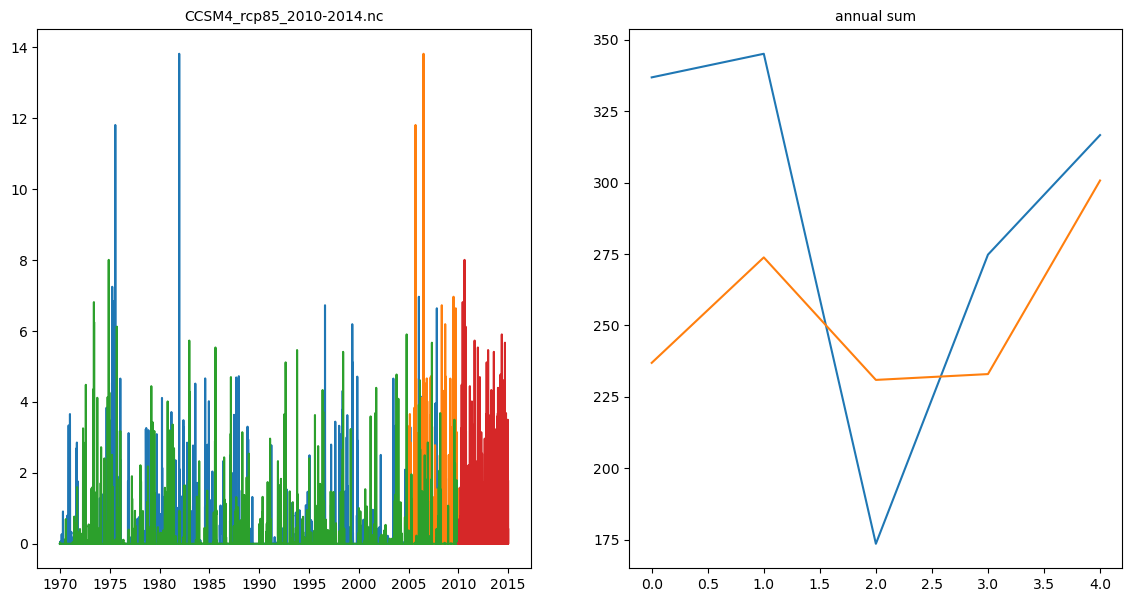

In [71]:
import cftime
path=path_bc; pcp_var='precip_dt'; lat_idx=150; lon_idx=150

files=sorted(glob.glob(f"{path}/{model}_{scen}/3hr/icar_3hr_livgrid_{model}_{scen}_*.nc"))

fig, ax = plt.subplots( 1, 2, figsize=(14,7))

for i,f in enumerate(files[:2]):
    ds=xr.open_dataset(f) 

    if ds.time.dt.calendar=='noleap':
        # time_np = xr.coding.times.decode_cf(ds['time'])
        # time_np = pd.to_datetime(ds.time.values)
        # time_np = ds.time.dt.to_pandas()
        time_np = ds.time.astype('datetime64[h]')
    else:
        time_np = ds.time
    print( ds.time.min().values, ds.time.max().values, min(time_np.values), max(time_np.values)) 

    ax[0].plot( ds[pcp_var].isel(lat=lat_idx).isel(lon=lon_idx) ) 
    ax[0].plot(time_np, ds[pcp_var].isel(lat=lat_idx).isel(lon=lon_idx) ) 
    ax[0].set_title( f.split('/')[-1].split('livgrid_')[-1] , fontsize=10)

    pcp_ann=ds[pcp_var].isel(lat=lat_idx).isel(lon=lon_idx).resample(time='1Y').sum()
    ax[1].plot( pcp_ann ) 
    ax[1].set_title( "annual sum" , fontsize=10)

In [ ]:

# model = "MPI-M.MPI-ESM1-2-LR"
# scen  = "ssp585"
model = "CCSM4"
scen  = "rcp85"

model = models[0]
scen = scenarios[0]

## precip at 150, 150:
plot_pcp_ts(model, scen, path=path_bc, dt='3hr',lat_idx=150, lon_idx=150)


## temperature @ 150,150
plot_ta2m_ts(model, scen, path=path_bc, dt='3hr',lat_idx=150, lon_idx=150)


### Plot maps of 5year max pcp

In [ ]:

def plot_pcpmax(model, scen, path=path_bc, dt='3hr'):
    if dt=='3hr':  pcp_var='precip_dt'
    elif dt=='daily':  pcp_var='Prec'
    
    files=sorted(glob.glob(f"{path}/{model}_{scen}/3hr/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    # print(f"  {model} {scen}: checking {len(files)} files ...")   

    fig, ax = plt.subplots( 5, 4, figsize=(15,12))

    for i,f in enumerate(files):
        ds=xr.open_dataset(f) 

        p1 = ax.flatten()[i].pcolormesh( ds[pcp_var].max(dim='time'), cmap='turbo', ) 
        cbar1 = fig.colorbar(p1, ax=ax.flatten()[i])
        ax.flatten()[i].set_title( f.split('/')[-1].split('livgrid_')[-1] , fontsize=10)
        
    fig.suptitle(" max 3hr pcp amount ")
    plt.show()

In [ ]:
model = models[1]
scen = scenarios[0]

t0 = time.time()

plot_pcpmax(model, scen, path=path_bc, dt='3hr')

print(time.time()-t0)

### Plot map of 5y Temperature max or min

In [74]:

def plot_Tmax(model, scen, path=path_bc, dt='3hr'):
    if dt=='3hr':  tvar='ta2m'
    elif dt=='daily':  tvar='Tmax'
    
    files=sorted(glob.glob(f"{path}/{model}_{scen}/{dt}/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    
    fig, ax = plt.subplots( 5, 4, figsize=(15,12))

    for i,f in enumerate(files):
        ds=xr.open_dataset(f) 
        print(f"  {f.split('/')[-1]} Tmin: {ds.ta2m.min().values} , Tmax: {ds.ta2m.max().values} ")
        # print(f"  {f.split('/')[-1]} Tmax: {ds.ta2m.max().values} ")
        p1 = ax.flatten()[i].pcolormesh( ds[tvar].max(dim='time'), cmap='turbo') 
        cbar1 = fig.colorbar(p1, ax=ax.flatten()[i])
        ax.flatten()[i].set_title( f.split('/')[-1].split('livgrid_')[-1] , fontsize=10)

    fig.suptitle(f" Max {dt} {tvar} ")
    plt.show()

  icar_3hr_livgrid_CCSM4_rcp45_2005-2009.nc Tmin: 216.66819763183594 , Tmax: 324.2622985839844 
  icar_3hr_livgrid_CCSM4_rcp45_2010-2014.nc Tmin: 222.69581604003906 , Tmax: 326.4822998046875 
  icar_3hr_livgrid_CCSM4_rcp45_2015-2019.nc Tmin: 215.08383178710938 , Tmax: 322.2593994140625 
  icar_3hr_livgrid_CCSM4_rcp45_2020-2024.nc Tmin: -206946.484375 , Tmax: 281374.53125 
  icar_3hr_livgrid_CCSM4_rcp45_2025-2029.nc Tmin: 217.10462951660156 , Tmax: 324.2622985839844 
  icar_3hr_livgrid_CCSM4_rcp45_2030-2034.nc Tmin: 216.36129760742188 , Tmax: 325.53948974609375 
  icar_3hr_livgrid_CCSM4_rcp45_2035-2039.nc Tmin: 217.72506713867188 , Tmax: 325.3523864746094 
  icar_3hr_livgrid_CCSM4_rcp45_2040-2044.nc Tmin: 216.73902893066406 , Tmax: 325.55523681640625 
  icar_3hr_livgrid_CCSM4_rcp45_2045-2049.nc Tmin: 219.28805541992188 , Tmax: 328.0958251953125 
  icar_3hr_livgrid_CCSM4_rcp45_2050-2054.nc Tmin: 220.59649658203125 , Tmax: 326.4832458496094 
  icar_3hr_livgrid_CCSM4_rcp45_2055-2059.nc Tmi

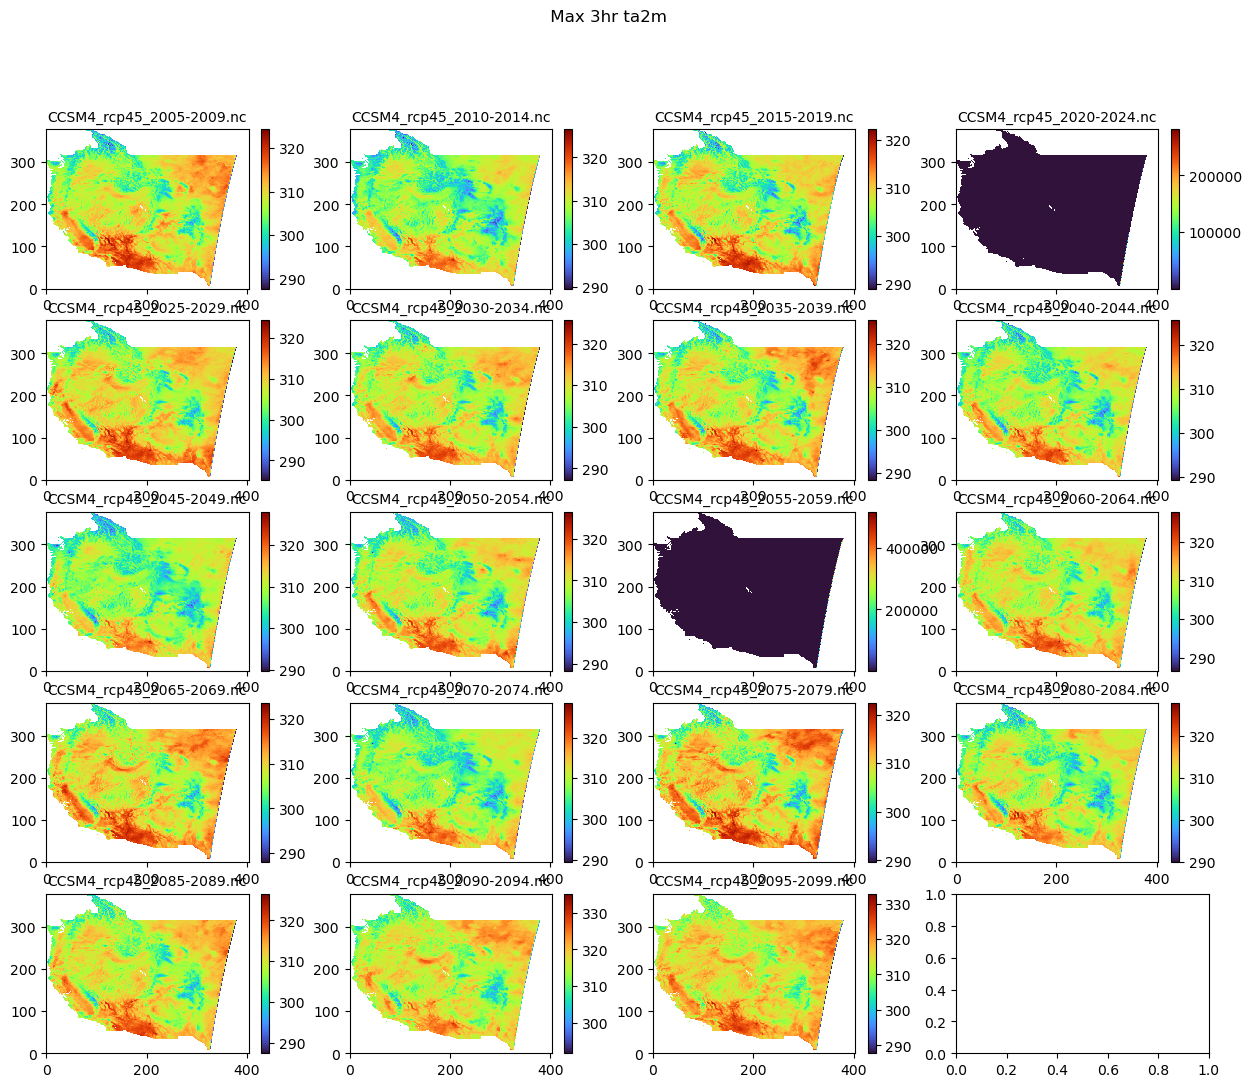

483.344601392746


In [75]:
model = models[1]
scen = scenarios[0]

t0 = time.time()

plot_Tmax(model, scen, path=path_bc, dt='3hr')

print(time.time()-t0)

In [76]:

def plot_Tmin(model, scen, path=path_bc, dt='3hr'):
    if dt=='3hr':  tvar='ta2m'
    elif dt=='daily':  tvar='Tmax'
    
    files=sorted(glob.glob(f"{path}/{model}_{scen}/{dt}/icar_3hr_livgrid_{model}_{scen}_*.nc"))
    
    fig, ax = plt.subplots( 5, 4, figsize=(18,21))

    for i,f in enumerate(files):
        ds=xr.open_dataset(f) 
    print(f"  {f.split('/')[-1]} Tmin: {ds.ta2m.min().values}  ")
        p1 = ax.flatten()[i].pcolormesh( ds[tvar].min(dim='time'), cmap='turbo') 
        cbar1 = fig.colorbar(p1, ax=ax.flatten()[i])
        ax.flatten()[i].set_title( f.split('/')[-1].split('livgrid_')[-1] , fontsize=10)

    fig.suptitle(f" Min {dt} {tvar} ")
    plt.show()

IndentationError: unexpected indent (2208244546.py, line 12)

In [ ]:
# model = "MPI-M.MPI-ESM1-2-LR"
# scen  = "ssp585"

t0 = time.time()

plot_Tmin(model, scen, path=path_bc, dt='3hr')

print(time.time()-t0)

### Check input for NANs

In [ ]:
var='rsds'

path="/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3"
# models = ["CanESM5", "CMCC-CM2-SR5", "MIROC-ES2L", "MPI-M.MPI-ESM1-2-LR", "NorESM2-MM"] 
models = ["MPI-M.MPI-ESM1-2-LR", "NorESM2-MM"] 
scenarios=["ssp245_2004","ssp245_2049","ssp370_2004","ssp370_2049","ssp585_2004","ssp585_2049", "hist"]

for model in models:
    for scen in scenarios:
        print(f" - - {model} {scen} - -")        
        files=sorted(glob.glob(f"{path}/{model}_{scen}/3hr/icar_3hr_livgrd_{model}_{scen.split('_')[0]}_*.nc"))
        # print(files)
        for f in files:
            dsl = xr.open_dataset( f )
            for t in range(len(dsl.time)):
                # print(t)
                cnt = np.count_nonzero(np.isnan(dsl[var].isel(time=t).values))
                if t==0:
                    cnt0 = cnt
                else:
                    if  cnt>cnt0: print(f" {dsl.time.isel(time=t).values} ")
            
print(f" - - {model} done - -")        

 - - MPI-M.MPI-ESM1-2-LR ssp245_2004 - -
 2050-01-01T03:00:00.000000000 
 2050-01-01T06:00:00.000000000 
 2050-01-01T09:00:00.000000000 
 2050-01-01T12:00:00.000000000 
 2050-01-01T15:00:00.000000000 
 2050-01-01T18:00:00.000000000 
 2050-01-01T21:00:00.000000000 
 - - MPI-M.MPI-ESM1-2-LR ssp245_2049 - -
 - - MPI-M.MPI-ESM1-2-LR ssp370_2004 - -
 - - MPI-M.MPI-ESM1-2-LR ssp370_2049 - -
 - - MPI-M.MPI-ESM1-2-LR ssp585_2004 - -
 - - MPI-M.MPI-ESM1-2-LR ssp585_2049 - -
 - - MPI-M.MPI-ESM1-2-LR hist - -
 - - NorESM2-MM ssp245_2004 - -
 - - NorESM2-MM ssp245_2049 - -


In [3]:
# tmask:
tmask=xr.open_dataset("/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_livBC3/Tmask.nc")
Tmask=tmask.__xarray_dataarray_variable__

In [4]:
def round_down_to_nearest_5(year):
    return (year // 5) * 5

In [5]:
model="MPI-M.MPI-ESM1-2-LR"
scen="ssp585_2049"
year=2066
year5=round_down_to_nearest_5(year)

In [6]:
# dsin=xr.open_mfdataset(
#     f"/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3/{model}_{scen}/3hr/icar_3hr_livgrd_{model}_{scen.split('_')[0]}_{str(year)}-*.nc"
# )

dsin5y=xr.open_mfdataset(
    # f"/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3/{model}_{scen}/3hr/icar_3hr_livgrd_{model}_{scen.split('_')[0]}_{str(year5)}-{str(year5+4)}.nc"
    f"/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3/{model}_{scen}/3hr/icar_3hr_livgrd_{model}_{scen.split('_')[0]}_206[5-9]-*.nc"
)

dsref=xr.open_mfdataset( # approximately, hist only
    f"/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3/{model}_hist/3hr/icar_3hr_livgrd_{model}_hist_*.nc"
)

In [10]:
dsr=xr.open_mfdataset(
    # "/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_3hr_month/{model}_{scen.split('_')[0]}_2004/icar_3hr_{model}_{scen.split('_')[0]}_2050-01.nc"
    f"/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_3hr_month/{model}_{scen}/icar_3hr_{model}_{scen.split('_')[0]}_{year}-*.nc"
   )

In [11]:
dspp=xr.open_mfdataset(
    f"/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_nocp_full/{model}_{scen}/3hr/icar_3hr_{model}_{scen.split('_')[0]}_{str(year)}-*.nc"
    # "/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3/{model}_{scen.split('_')[0]}_2004/3hr/icar_3hr_livgrd_{model}_{scen.split('_')[0]}_2050-01.nc"
    # "/glade/derecho/scratch/bkruyt/CMIP6/WUS_icar_LivGrd3/{model}_{scen.split('_')[0]}_2004/3hr/icar_3hr_livgrd_{model}__{scen.split('_')[0]}_2050-01.nc"
)

In [13]:
dsout=xr.open_dataset(
    f"/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_livBC3/{model}_{scen.split('_')[0]}/3hr/icar_3hr_livgrid_{model}_{scen.split('_')[0]}_{str(year5)}-{str(year5+4)}.nc"
)
dsout2=xr.open_dataset(
    f"/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_livBC4/{model}_{scen.split('_')[0]}/3hr/icar_3hr_livgrid_{model}_{scen.split('_')[0]}_{str(year5)}-{str(year5+4)}.nc"
)

In [ ]:
# np.where(dsin.ta2m.isel(lon=slice(None, -105)).values==0.)
np.nanmin(dsin.ta2m.isel(lon=slice(None, -104)) )

### Livneh Temperature [degC]

In [7]:
import warnings
# from pandas.errors import SerializationWarning  # Adjust based on the source of your warning

# Suppress SerializationWarning
warnings.filterwarnings("ignore") #, category=SerializationWarning)


In [8]:
tfiles = glob.glob("/glade/campaign/ral/hap/common/Livneh_met_updated/temp_and_wind/livneh_lusu_2020_temp_and_wind.2021-05-02.19[5-9]*.nc")
tfiles.extend(glob.glob("/glade/campaign/ral/hap/common/Livneh_met_updated/temp_and_wind/livneh_lusu_2020_temp_and_wind.2021-05-02.20*.nc"))
tfiles.sort()
print('   ',len(tfiles), " Livneh temperature files(years)" ) # the number of files (years)

livneht = xr.open_mfdataset(tfiles,parallel=True)

    69  Livneh temperature files(years)


In [9]:
icar_1file=dsin5y.isel(time=0)

In [10]:
# # # crop livneh to ICAR bounds:
max_lat=icar_1file.lat.max().values#+buff
min_lat=icar_1file.lat.min().values#-buff
max_lon=icar_1file.lon.max().values#+buff
min_lon=icar_1file.lon.min().values#-buff

LatIndexer, LonIndexer = 'lat', 'lon'

livneht = livneht.sel(**{LatIndexer: slice(min_lat, max_lat ),
                        LonIndexer: slice(min_lon, max_lon)})



### Bias corr for small subset

In [11]:
####################################
a=252; b=314

# input
ta2m = dsin5y["ta2m"][:,a-2:a+2, b-2:b+2]
tmin = ta2m.resample(time='1D').min(dim='time').load()
tmax = ta2m.resample(time='1D').max(dim='time').load()

# liv
livneh_tmin = livneht["Tmin"][:,a-2:a+2, b-2:b+2].load() # + 273.15    #.load()
livneh_tmax = livneht["Tmax"][:,a-2:a+2, b-2:b+2].load() # + 273.15    #.load()

# Ref
dsTmin_ref = dsref.ta2m[:,a-2:a+2, b-2:b+2].resample(time='1D').min(dim='time').load()
dsTmax_ref = dsref.ta2m[:,a-2:a+2, b-2:b+2].resample(time='1D').max(dim='time').load()

In [27]:
idx = np.where(dsin5y.time.diff(dim='time').values> dsin5y.time.diff(dim='time').min().values )
print( dsin5y.time.values[idx[0][0]-2: idx[0][0]+2 ] )
print( dsin5y.time.values[idx[0][1]-2: idx[0][1]+2 ] )

['2065-04-30T12:00:00.000000000' '2065-04-30T15:00:00.000000000'
 '2065-04-30T18:00:00.000000000' '2065-05-01T00:00:00.000000000']
['2065-09-20T15:00:00.000000000' '2065-09-20T18:00:00.000000000'
 '2065-09-20T21:00:00.000000000' '2065-09-24T00:00:00.000000000']


In [12]:
%%time
# qmap
print("   quantile mapping t_min")
bc_tmin = quantile_mapping.quantile_mapping_by_group(
     tmin, dsTmin_ref, livneh_tmin, detrend=False, extrapolate="1to1", grouper='time.month' , n_endpoints=50
    )

   quantile mapping t_min
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_end

In [13]:
%%time
print("   quantile mapping t_max")
bc_tmax = quantile_mapping.quantile_mapping_by_group(
    tmax, dsTmax_ref, livneh_tmax,   detrend=False, extrapolate="1to1", grouper='time.month' , n_endpoints=50
    )

   quantile mapping t_max
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_endpoints': 50}
putting the trend back
kwargs: {'alpha': 0.4, 'beta': 0.4, 'extrapolate': '1to1', 'n_end

In [ ]:
print(f"   min input ta2m: {np.nanmin(ta2m.values )}  (K)")
print(f"   min daily bc tmin: {np.nanmin(bc_tmin.values )} (C)")
print(f"   max daily bc tmax: {np.nanmax(bc_tmax.values )} (C)")



# - - - - - apply correction to n-hr data  - - - -
t0 = time.time()
print("   applying correction to "+str(tdelta_int)+"-hourly data")

for i in range(len(ta2m.time)):
    t = int(i/(24/tdelta_int))

    dtr = (tmax[t] - tmin[t]).values
    dtr[dtr<0.001] = 0.001
    if dtr<0 : print( f"   dtr: {dtr}")
        
    # this_ds["ta2m"][i] -= tmin[t]
    # this_ds["ta2m"][i] /= dtr
    # this_ds["ta2m"][i] *= np.abs(bc_tmax[t] - bc_tmin[t])
    # this_ds["ta2m"][i] += bc_tmin[t]+273.15
    
    ta2m[i] -= tmin[t]
    if ta2m[i].any()<0 :
        print(f"   ta2m[i] -= tmin[t]: {ta2m[i]}")
    ta2m[i] /= dtr
    if ta2m[i].any()<0 : print(f"   ta2m[i] /= dtr: {ta2m[i] }")
    ta2m[i] *= np.abs(bc_tmax[t] - bc_tmin[t])
    if ta2m[i].any()<0 : print(f"   ta2m[i] *= np.abs(bc_tmax[t] - bc_tmin[t]): {ta2m[i] }")
    ta2m[i] += bc_tmin[t]+273.15
    if ta2m[i].any()<0 : print(f"   ta2m[i] += bc_tmin[t]+273.15: {ta2m[i] }")

print(f"   min output ta2m: {np.nanmin( ta2m.values )}")

### (visually) find low temps

Text(0.5, 0.98, 'airtemp 2066-01-14T09 (MPI-M.MPI-ESM1-2-LR ssp585_2049)')

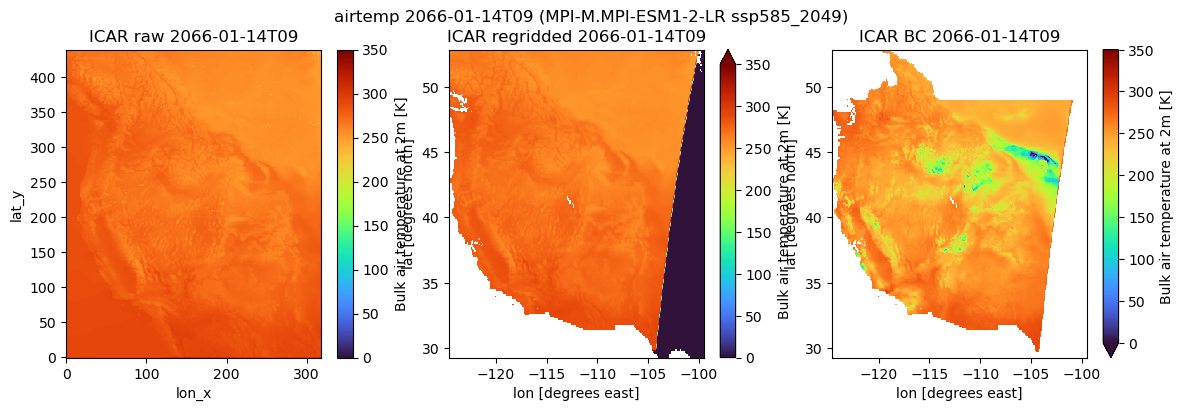

In [54]:
fig, ax =plt.subplots(1,3, figsize=(14,4))
vmin=0; vmax=350
t1 = "2066-01-14T09"
dspp.ta2m.sel(time=t1).plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[0])
dsin.ta2m.sel(time=t1).plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[1])
# dsout.ta2m.sel(time=t1).plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[2])
dsout2.ta2m.sel(time=t1).plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[2])

ax[0].set_title(f"ICAR raw {t1}")
ax[1].set_title(f"ICAR regridded {t1}")
ax[2].set_title(f"ICAR BC {t1}")
fig.suptitle(f"airtemp {t1} ({model} {scen})")

In [32]:
# np.where(dsout.lat.values>45)
np.where(dsout.lon.values>-105)

(array([314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
        327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339,
        340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
        353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
        366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378,
        379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
        392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402]),)

In [66]:
idx = np.where(dsout[var].values <100 )
idx

(array([  959,   959,   959, ..., 14555, 14556, 14559]),
 array([  7,   8,   9, ..., 155, 163, 163]),
 array([326, 326, 326, ..., 117,  81,  81]))

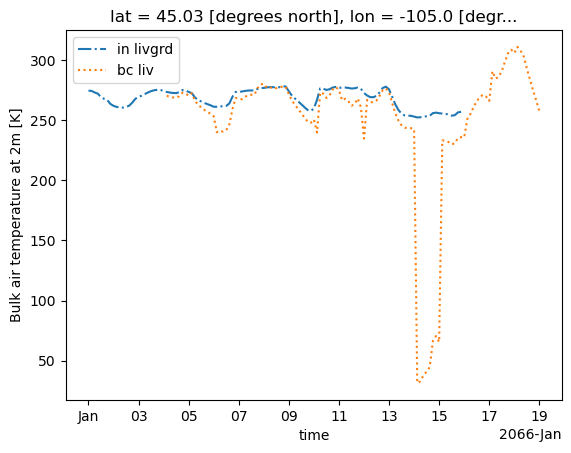

In [56]:
var='ta2m'
t0=(year-year5)*365*8 # roughly
t1=(year-1950)*365 # roughly
dt=120 ; a=252; b=314
# dsr[var][:dt,a,b].plot(label='raw')  # different grid
# dspp[var][:dt,a,b].plot(label='post processed')
dsin[var][:dt,a,b].plot(linestyle="-.",label='in livgrd')
dsout[var][t0:t0+dt,a,b].plot(linestyle=":",label='bc liv')
# dsout2[var][t1:t1+dt,a,b].plot(linestyle="--",label='bc liv2')
# livneht.Tmin[t1:t1+dt,a,b].plot(linestyle="-.",label='livneh')
plt.legend()
plt.show()

Text(0.5, 0.98, 'min airtemp 2066 (MPI-M.MPI-ESM1-2-LR ssp585_2049)')

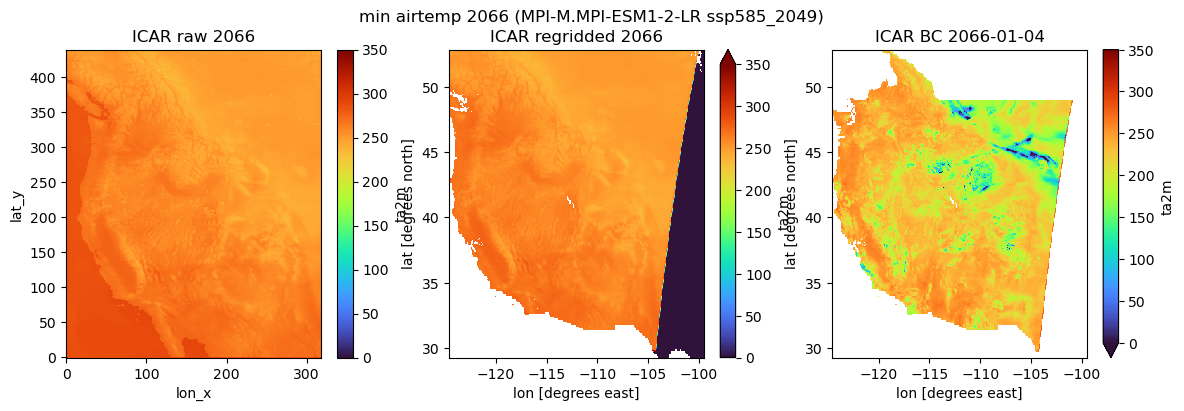

In [19]:
fig, ax =plt.subplots(1,3, figsize=(14,4))
vmin=0; vmax=350
dspp.ta2m.min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[0])
dsin.ta2m.min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[1])
# dsout.ta2m.isel(time=slice(t0,t0+365)).min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[2])
dsout2.ta2m.isel(time=slice(t0,t0+365)).min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[2])

ax[0].set_title(f"ICAR raw {str(year)}")
ax[1].set_title(f"ICAR regridded {str(year)}")
ax[2].set_title(f"ICAR BC {str(dsout.time[t0].values)[:10]}")
fig.suptitle(f"min airtemp {str(year)} ({model} {scen})")

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 378, lon: 403)>
[152334 values with dtype=bool]
Coordinates:
  * lat      (lat) float64 29.28 29.34 29.41 29.47 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -99.59 -99.53 -99.47

In [63]:
dsref.ta2m.where(tmask.__xarray_dataarray_variable__).min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[0])

Text(0.5, 0.98, 'min airtemp 2066 (MPI-M.MPI-ESM1-2-LR ssp585_2049)')

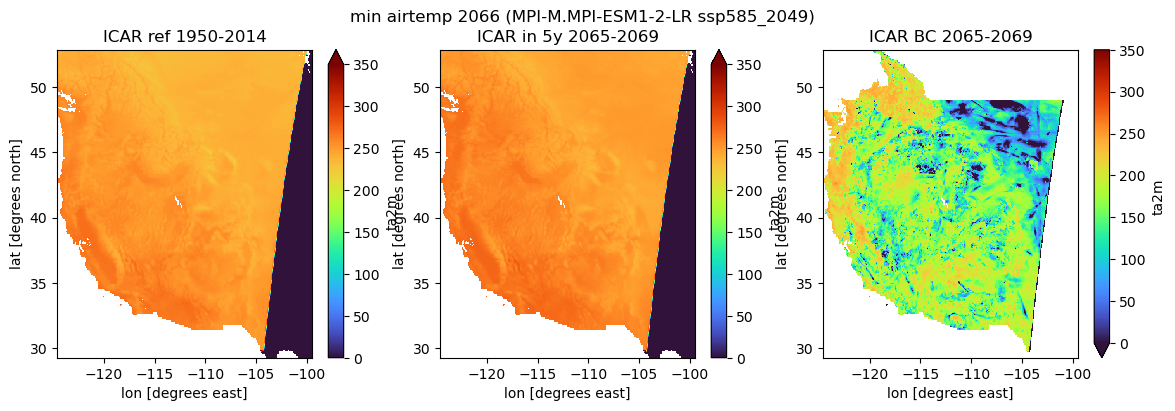

In [49]:
fig, ax =plt.subplots(1,3, figsize=(14,4))
vmin=0; vmax=350
dsref.ta2m.min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[0])
dsin5y.ta2m.min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[1])
# dsout.ta2m.isel(time=slice(t0,t0+365)).min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[2])
dsout2.ta2m.min(dim='time').plot.pcolormesh(vmin=vmin, vmax=vmax, cmap='turbo', ax=ax[2])

ax[0].set_title(f"ICAR ref 1950-2014")
ax[1].set_title(f"ICAR in 5y {str(year5)}-{str(year5+4)}")
ax[2].set_title(f"ICAR BC {str(year5)}-{str(year5+4)}")
fig.suptitle(f"min airtemp {str(year)} ({model} {scen})")

### look at distributions:

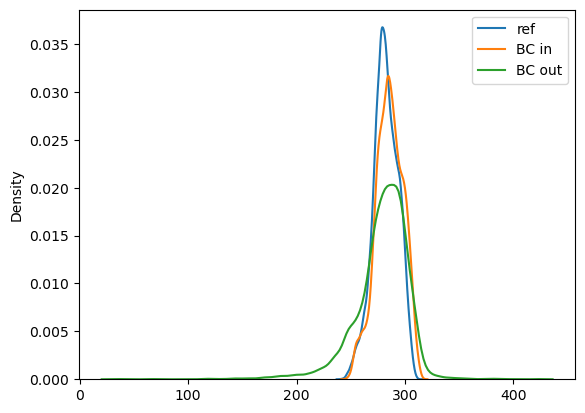

In [65]:

sns.kdeplot( dsref.ta2m.values[:,a,b] , label='ref')
sns.kdeplot( dsin5y.ta2m.values[:,a,b] , label='BC in')
sns.kdeplot( dsout.ta2m.values[:,a,b] , label='BC out')

plt.legend()
plt.show()

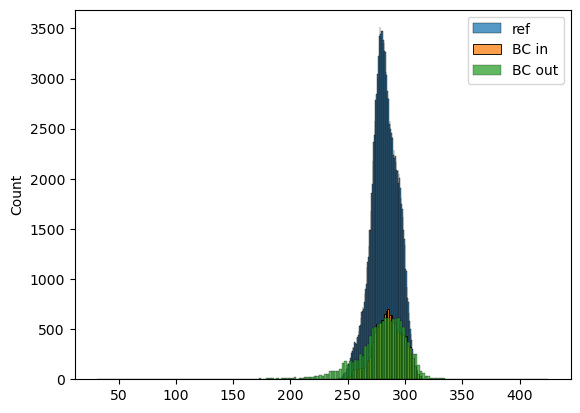

In [15]:
kde=False
a=252; b=314
sns.histplot( dsref.ta2m.values[:,a,b] , label='ref', kde=kde)
sns.histplot( dsin5y.ta2m.values[:,a,b] , label='BC in', kde=kde)
sns.histplot( dsout.ta2m.values[:,a,b] , label='BC out', kde=kde)

plt.legend()
plt.show()

### resample 2 daily 

In [12]:
a=252; b=314
dsref_Tmin = dsref.ta2m[:,a,b].resample(time='D').min().load()

In [13]:
dsin_Tmin  = dsin5y.ta2m[:,a,b].resample(time='D').min().load()

In [14]:
dsout_Tmin = dsout.ta2m[:,a,b].resample(time='D').min().load()

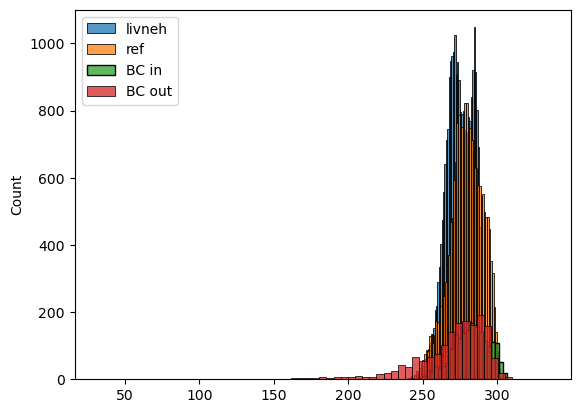

In [19]:

sns.histplot( livneht.Tmin[:,a,b]+273.5, label='livneh')
sns.histplot( dsref_Tmin , label='ref')
sns.histplot( dsin_Tmin , label='BC in')
sns.histplot( dsout_Tmin , label='BC out')

plt.legend()
plt.show()

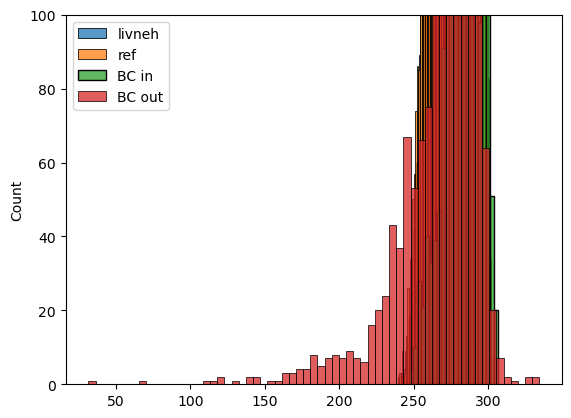

In [21]:

sns.histplot( livneht.Tmin[:,a,b]+273.5, label='livneh')
sns.histplot( dsref_Tmin , label='ref')
sns.histplot( dsin_Tmin , label='BC in')
sns.histplot( dsout_Tmin , label='BC out')

plt.ylim(None, 100)
plt.legend()
plt.show()

In [23]:
livneht.Tmin.attrs

{'units': 'degC', 'long_name': 'Minimum daily air temperature'}

In [ ]:
livneht.Tmin.min(dim='time').plot.pcolormesh(vmin=-70, vmax=30, cmap='turbo')

In [ ]:
livneht.Tmax.max(dim='time').plot.pcolormesh(vmin=0, vmax=70, cmap='turbo')

In [16]:
# # path="/global/cfs/cdirs/m4062/CMIP6/WUS/WUS_icar_livBC3"
# # model="MPI-M.MPI-ESM1-2-LR"
# # scen="ssp585"
# dsout=xr.open_dataset(
#     "/glade/campaign/ral/hap/bert/CMIP6/WUS_icar_livBC3/MPI-M.MPI-ESM1-2-LR_ssp585/3hr/icar_3hr_livgrid_MPI-M.MPI-ESM1-2-LR_ssp585_2065-2069.nc"
# )

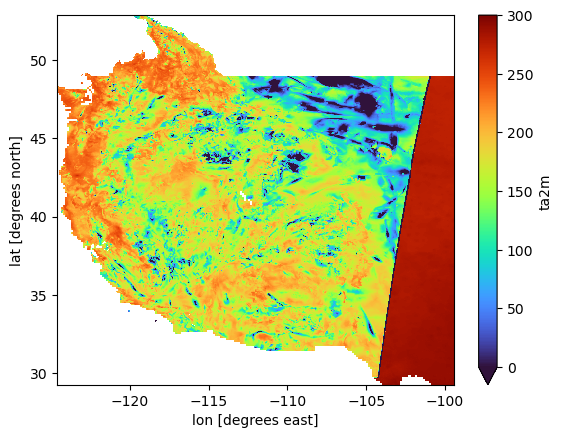

In [24]:
dsout.ta2m.min(dim='time').plot.pcolormesh(vmin=0, vmax=300, cmap='turbo')

In [21]:
# ds.ta2m.min(dim='time').plot.pcolormesh()

In [ ]:
path="/glade/campaign/ral/hap/bert/CMIP5/WUS_icar_livBC/CanESM2_historical/3hr"
files=sorted(glob.glob( f"{path}/*.nc"))
# files

In [5]:
ds=xr.open_dataset(files[0])
ds

<xarray.Dataset>
Dimensions:    (time: 14600, lat: 378, lon: 403)
Coordinates:
  * time       (time) object 1950-01-01 00:00:00 ... 1954-12-31 21:00:00
  * lat        (lat) float64 29.28 29.34 29.41 29.47 ... 52.66 52.72 52.78 52.84
  * lon        (lon) float64 -124.6 -124.5 -124.5 ... -99.59 -99.53 -99.47
Data variables:
    rsds       (time, lat, lon) float32 ...
    rlds       (time, lat, lon) float32 ...
    u10m       (time, lat, lon) float32 ...
    v10m       (time, lat, lon) float32 ...
    ta2m       (time, lat, lon) float32 ...
    psfc       (time, lat, lon) float32 ...
    precip_dt  (time, lat, lon) float32 ...
    relhum2m   (time, lat, lon) float32 ...
Attributes:
    regrid_method:  conservative

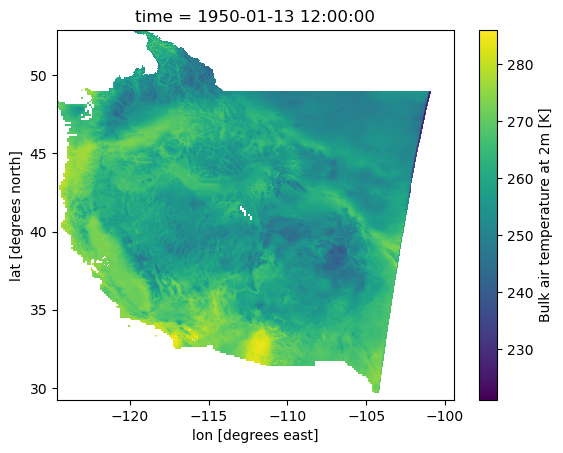

In [8]:
ds.ta2m.isel(time=100).plot()

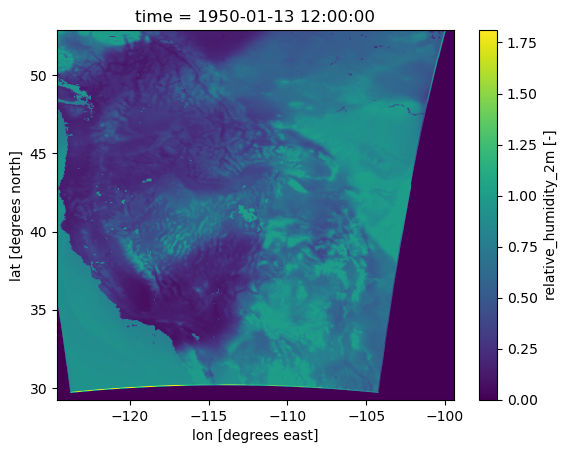

In [9]:
ds.relhum2m.isel(time=100).plot()